### IMPORTANDO BIBLIOTECAS/MÓDULOS

In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sa
import warnings
import joblib

### CRIANDO SÉRIE TEMPORAL

In [2]:
np.random.seed(0)
data = np.random.normal(3000,1000,200)
serie = pd.DataFrame(data, columns=['Serie'])

### ANALISANDO SÉRIE TEMPORAL

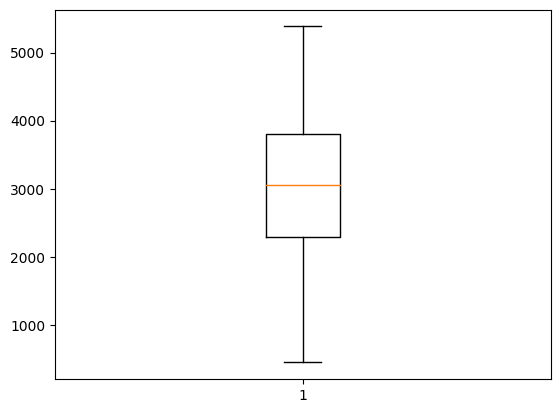

In [3]:
plt.boxplot(serie)
plt.show()

### PLOTANDO SÉRIE

<Axes: >

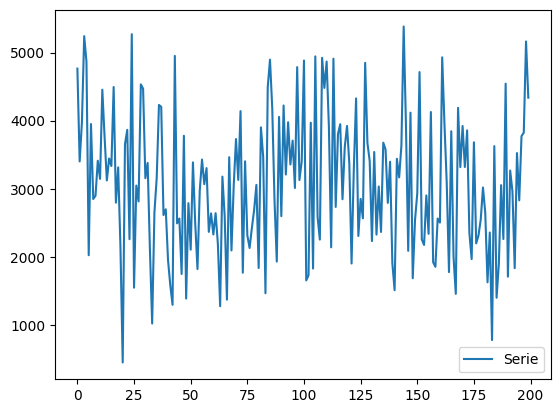

In [4]:
serie.plot()

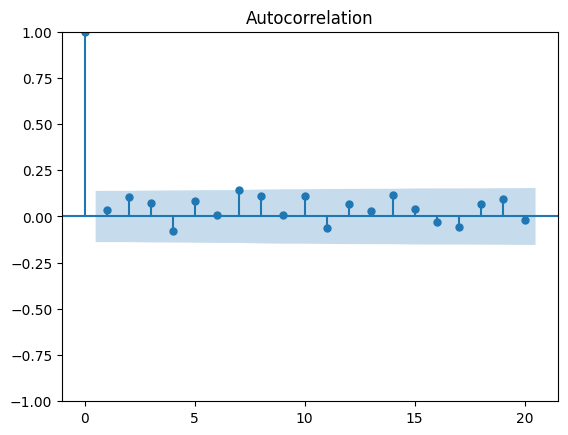

In [5]:
plot_acf(serie, lags=20)
plt.show()

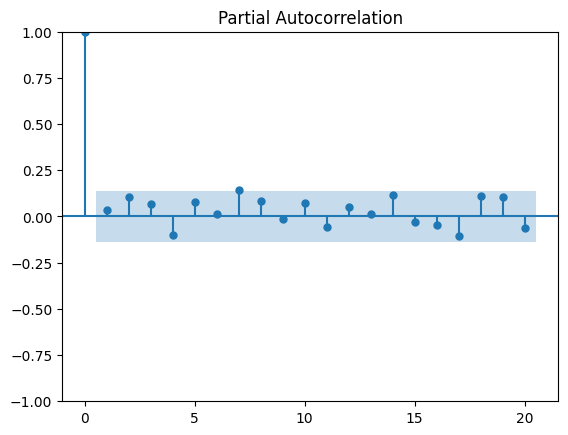

In [6]:
plot_pacf(serie, lags=20)
plt.show()

### DEFININDO BASE TREINO E TESTE

In [7]:
treino = serie['Serie'][:int(len(serie) * 0.8)]
teste = serie['Serie'][int(len(serie) * 0.8):]

print(treino.shape)
print(teste.shape)

(160,)
(40,)


### CONFIGURANDO E TREINANDO OS MODELOS ARIMA E SARIMAX

###### NO MODELO ARIMA, NÃO FOI NECESSÁRIO INCLUIR DIFERENCIAÇÃO, POIS A SÉRIE É ESTACIONÁRIA, TORNANDO O MODELO COMO 'ARMA'

In [21]:
#ARIMA

warnings.filterwarnings('ignore')

def testar(folds):
    order = (folds.suggest_int('p', 2,40),
             folds.suggest_int('d', 0,2),
             folds.suggest_int('q', 1,3)
             )
    model = ARIMA(treino, order=order).fit()
    predictions = model.forecast(steps=int(len(teste)))

    rsme = np.sqrt(mean_squared_error(teste, predictions))
    return rsme

study = optuna.create_study(direction='minimize')
study.optimize(testar, n_trials=50)

best_params = study.best_params
modelo = ARIMA(treino, order=(best_params['p'],best_params['d'],best_params['q'])).fit()

[I 2024-01-31 18:07:41,185] A new study created in memory with name: no-name-4921f08f-264b-4034-8ae2-d86831e23c8b
[I 2024-01-31 18:07:41,905] Trial 0 finished with value: 1180.4957746769508 and parameters: {'p': 9, 'd': 2, 'q': 3}. Best is trial 0 with value: 1180.4957746769508.
[I 2024-01-31 18:07:49,223] Trial 1 finished with value: 1007.8847825106842 and parameters: {'p': 35, 'd': 1, 'q': 2}. Best is trial 1 with value: 1007.8847825106842.
[I 2024-01-31 18:07:49,449] Trial 2 finished with value: 1022.2423512471094 and parameters: {'p': 6, 'd': 1, 'q': 2}. Best is trial 1 with value: 1007.8847825106842.
[I 2024-01-31 18:07:51,434] Trial 3 finished with value: 1017.6902998800823 and parameters: {'p': 20, 'd': 0, 'q': 1}. Best is trial 1 with value: 1007.8847825106842.
[I 2024-01-31 18:07:52,500] Trial 4 finished with value: 1070.5243923049493 and parameters: {'p': 14, 'd': 1, 'q': 2}. Best is trial 1 with value: 1007.8847825106842.
[I 2024-01-31 18:07:52,983] Trial 5 finished with val

In [9]:
#SARIMAX

def testar_sa(folds):
    order = (
            folds.suggest_int('p', 2,11),
            folds.suggest_int('d', 0,2),
            folds.suggest_int('q', 1,10)
             )
    seasonal_order = (
            #folds.suggest_int('P', 1,10),
            #folds.suggest_int('D', 0,2),
            #folds.suggest_int('Q', 1,10),
            #folds.suggest_int('m', 12,20)
                4,1,1,12
            )
    model = sa.tsa.SARIMAX(treino, order=order, seasonal_order=seasonal_order).fit()
    predictions = model.forecast(steps=int(len(teste)))

    rsme = np.sqrt(mean_squared_error(teste, predictions))
    return rsme

study_sa = optuna.create_study(direction='minimize')
study_sa.optimize(testar_sa, n_trials=10)

best_params = study_sa.best_params
modelo_sa = sa.tsa.SARIMAX(treino, order=(best_params['p'],best_params['d'],best_params['q']), 
                           seasonal_order=(4,1,1,12)).fit()

[I 2024-01-31 17:50:15,082] A new study created in memory with name: no-name-8174b2ae-9474-49bb-8ad1-21c5e6df524d
[I 2024-01-31 17:50:52,396] Trial 0 finished with value: 1415.9139116469303 and parameters: {'p': 4, 'd': 2, 'q': 10}. Best is trial 0 with value: 1415.9139116469303.
[I 2024-01-31 17:51:22,266] Trial 1 finished with value: 1084.8688955531998 and parameters: {'p': 6, 'd': 1, 'q': 2}. Best is trial 1 with value: 1084.8688955531998.
[I 2024-01-31 17:51:53,123] Trial 2 finished with value: 1138.021894558555 and parameters: {'p': 5, 'd': 1, 'q': 3}. Best is trial 1 with value: 1084.8688955531998.
[I 2024-01-31 17:52:02,702] Trial 3 finished with value: 1117.214414613245 and parameters: {'p': 3, 'd': 1, 'q': 7}. Best is trial 1 with value: 1084.8688955531998.
[I 2024-01-31 17:52:42,852] Trial 4 finished with value: 1076.2437437901783 and parameters: {'p': 8, 'd': 0, 'q': 6}. Best is trial 4 with value: 1076.2437437901783.
[I 2024-01-31 17:53:31,039] Trial 5 finished with value: 

### AVALIANDO TREINAMENTO DOS MODELOS ARIMA E SARIMAX

In [10]:
residuals = pd.DataFrame(modelo.resid)
residuals_sa = pd.DataFrame(modelo_sa.resid)

In [11]:
print(modelo.summary())

                               SARIMAX Results                                
Dep. Variable:                  Serie   No. Observations:                  160
Model:                 ARIMA(5, 0, 3)   Log Likelihood               -1330.350
Date:                Wed, 31 Jan 2024   AIC                           2680.700
Time:                        17:56:24   BIC                           2711.452
Sample:                             0   HQIC                          2693.187
                                - 160                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3103.6838    208.254     14.903      0.000    2695.513    3511.855
ar.L1          1.3353      0.618      2.161      0.031       0.124       2.546
ar.L2          0.2642      1.225      0.216      0.8

In [12]:
print(modelo_sa.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Serie   No. Observations:                  160
Model:             SARIMAX(8, 0, 8)x(4, 1, [1], 12)   Log Likelihood               -1240.119
Date:                              Wed, 31 Jan 2024   AIC                           2524.238
Time:                                      17:56:24   BIC                           2590.177
Sample:                                           0   HQIC                          2551.029
                                              - 160                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2501      1.374     -0.182      0.856      -2.942       2.442
ar.L2         -0.34

<Axes: ylabel='Density'>

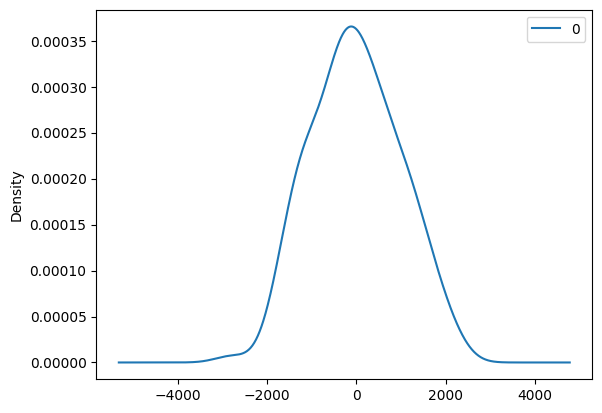

In [13]:
residuals.plot(kind='kde')

<Axes: ylabel='Density'>

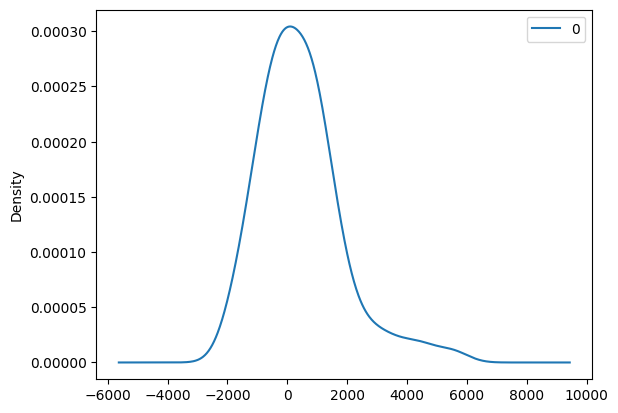

In [14]:
residuals_sa.plot(kind='kde')

### REALIZANDO PREVISÕES E COMPARANDO COM A BASE DE TESTE

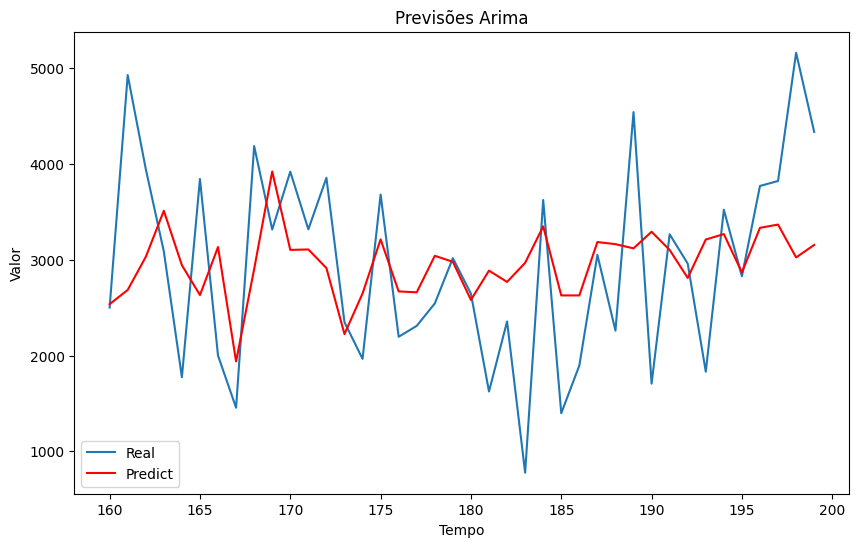

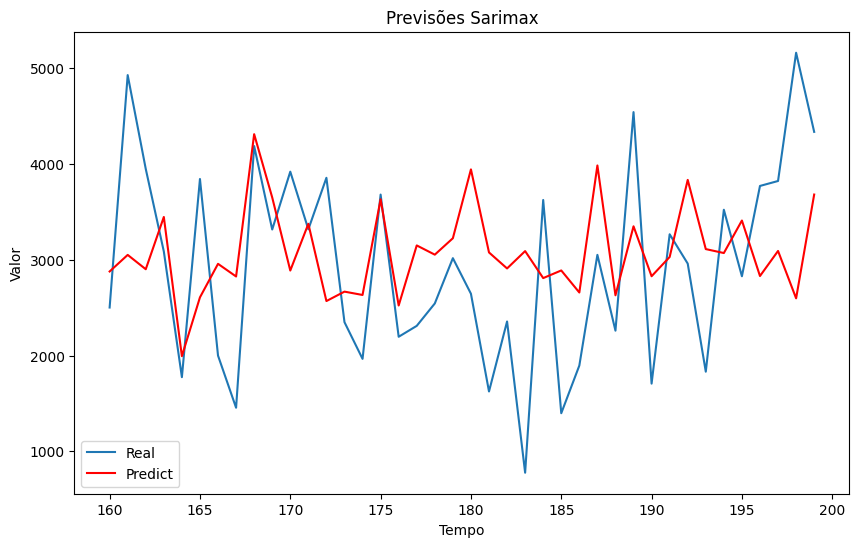

In [22]:
n_forecast = len(teste)
forecast = modelo.forecast(steps=n_forecast)
forcast_sa = modelo_sa.forecast(steps=n_forecast)

predicts = [forecast,forcast_sa]

plt.figure(figsize=(10, 6))
plt.plot(teste)
plt.plot(forecast, color='red')
plt.title('Previsões Arima')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend(['Real', 'Predict'])

plt.figure(figsize=(10, 6))
plt.plot(teste)
plt.plot(forcast_sa, color='red')
plt.title('Previsões Sarimax')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend(['Real', 'Predict'])

plt.show()

### SALVANDO MODELOS

In [16]:
#joblib.dump(modelo,'arima.pkl')
#joblib.dump(modelo_sa,'sarimax.pkl')

### CARREGANDO MODELOS

In [17]:
#arima = joblib.load('arima.pkl')
#sarima = joblib.load('sarimax.pkl')